In [1]:
import cv2
import glob
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import pandas as pd
import xgboost as xgb

from skimage import color
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from scipy.ndimage.measurements import label

In [2]:
nonvehicles = pd.DataFrame(glob.glob('data/non-vehicles/*/*.png'), columns=['filename'])
nonvehicles = nonvehicles.sample(8000)
nonvehicles['auto'] = 0 

In [3]:
vehicles = pd.DataFrame(glob.glob('data/vehicles/*/*.png'), columns=['filename'])
vehicles = vehicles.sample(8000)
vehicles['auto'] = 1

In [4]:
data = nonvehicles.append(vehicles)
data = shuffle(data)

In [5]:
image = mpimg.imread(data.sample(1).iloc[0].filename)

print(image.shape)

(64, 64, 3)


In [6]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return  hist_features

In [7]:
def extract_features(rgb):
    gray = color.rgb2gray(rgb)
    hog_features = hog(gray, feature_vector=True)
    lab = color.rgb2lab(rgb)
    luv = color.rgb2luv(rgb)
    hsv = color.rgb2hsv(rgb)
    rgb_hist_features = color_hist(rgb)
    hsv_hist_features = color_hist(hsv)
    luv_hist_features = color_hist(luv)
    lab_hist_features = color_hist(lab)

    return np.hstack([
            hog_features, 
            rgb_hist_features, 
            hsv_hist_features, 
            lab_hist_features,
            luv_hist_features]).astype(np.float64)

In [8]:
features = []
labels   = []
for i, row in data.iterrows():
    image = mpimg.imread(row['filename'])
    features.append(extract_features(image))
    labels.append(row['auto'])

print(len(features))
print(len(labels))

16000
16000


In [9]:
from sklearn.feature_selection import VarianceThreshold


new_features = np.array(features)

selector = VarianceThreshold(0.0002)
selector.fit(new_features)

print(new_features.shape)

new_features = selector.transform(new_features)

print(new_features.shape)

(16000, 3300)
(16000, 1471)


In [10]:
X_scaler = StandardScaler().fit(new_features)
scaled_features = X_scaler.transform(new_features)

In [11]:
X_training, X_test, y_training, y_test = train_test_split(scaled_features, labels, test_size=0.33, random_state=42)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_training, y_training, test_size=0.33, random_state=42)

In [13]:
params = {
    'bst:max_depth': 2, 
    'bst:eta'      : 1, 
    'silent'       : 0, 
    'objective'    : 'binary:logistic',
    'nthread'      : 4,
    'eval_metric'  : 'auc'
}

num_round = 80

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)
dtest  = xgb.DMatrix(X_test)

evallist  = [(dvalid, 'eval'), (dtrain, 'train')]

In [14]:
bst = xgb.train(params, dtrain, num_round, evallist)

[0]	eval-auc:0.986865	train-auc:0.991229
[1]	eval-auc:0.992255	train-auc:0.995665
[2]	eval-auc:0.994235	train-auc:0.997212
[3]	eval-auc:0.995916	train-auc:0.998
[4]	eval-auc:0.997995	train-auc:0.999707
[5]	eval-auc:0.997897	train-auc:0.999763
[6]	eval-auc:0.998443	train-auc:0.999843
[7]	eval-auc:0.999012	train-auc:0.999957
[8]	eval-auc:0.999137	train-auc:0.999983
[9]	eval-auc:0.999282	train-auc:0.999989
[10]	eval-auc:0.999273	train-auc:0.999995
[11]	eval-auc:0.999459	train-auc:0.999997
[12]	eval-auc:0.999479	train-auc:0.999999
[13]	eval-auc:0.99946	train-auc:1
[14]	eval-auc:0.999597	train-auc:1
[15]	eval-auc:0.999612	train-auc:1
[16]	eval-auc:0.999678	train-auc:1
[17]	eval-auc:0.999673	train-auc:1
[18]	eval-auc:0.999726	train-auc:1
[19]	eval-auc:0.999753	train-auc:1
[20]	eval-auc:0.999774	train-auc:1
[21]	eval-auc:0.99978	train-auc:1
[22]	eval-auc:0.999778	train-auc:1
[23]	eval-auc:0.999783	train-auc:1
[24]	eval-auc:0.999784	train-auc:1
[25]	eval-auc:0.999795	train-auc:1
[26]	eval-auc:

In [15]:
y_pred = bst.predict(dtest)
y_pred

array([  9.99107182e-01,   1.72304048e-04,   7.03427577e-05, ...,
         3.86435888e-04,   9.99601424e-01,   9.99826372e-01], dtype=float32)

In [16]:
y_pred = y_pred > 0.9  
y_pred = y_pred.astype(int)
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [17]:
confusion_matrix(y_test, y_pred)

array([[2677,    2],
       [  42, 2559]])

In [18]:
dall = xgb.DMatrix(scaled_features)
py = bst.predict(dall)
py = py > 0.9
py = py.astype(int)

In [19]:
confusion_matrix(labels, py)

array([[7998,    2],
       [  73, 7927]])

In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color, thick)
    return imcopy

In [21]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1

    window_list = []
    images_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))
            
            window = np.zeros(xy_window)
            window = img[starty:endy,startx:endx,:]
            window = cv2.resize(window, (64,64))
            images_list.append(extract_features(window))

    return np.array(window_list), np.array(images_list)

In [22]:
def detect_cars(image):
    window_list1, images_list1 = slide_window(image, [450, None], [400, 550], ( 96,  96), (0.5, 0.5))
    window_list2, images_list2 = slide_window(image, [640, None], [400, 600], (128, 128), (0.5, 0.5))
    window_list3, images_list3 = slide_window(image, [500, 1000], [400, 500], ( 64,  64), (0.5, 0.5))
    
    window_list = np.concatenate((
            window_list3, 
            window_list2, 
            window_list1), axis=0)
    images_list = np.concatenate((
            images_list3, 
            images_list2, 
            images_list1), axis=0)

    images_list = selector.transform(images_list)
    scaled      = X_scaler.transform(images_list)
    pred        = bst.predict(xgb.DMatrix(scaled))            
    
    heatmap = np.zeros(image.shape[0:2])
    
    for prob, pts in zip(pred, window_list):
        x1, y1 = pts[0]
        x2, y2 = pts[1]
        if prob > 0.99:
            heatmap[y1:y2,x1:x2] += 1
     
    return heatmap

In [23]:
def draw_labeled_bboxes(img, heatmap):
    img_height, img_width = img.shape[0:2]
    labels = label(heatmap)

    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,102,204), 6)
    return img

In [24]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [25]:
class VehicleDetector:
    def __init__(self, image_shape):
        self.prev_heatmap = np.zeros(image_shape)

    def process_image(self, image):
        img = np.copy(image).astype(np.uint8)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img[:,:,0] = clahe.apply(img[:,:,0])
        img[:,:,1] = clahe.apply(img[:,:,1])
        img[:,:,2] = clahe.apply(img[:,:,2]) 
        
        png = img.astype(np.float32)/255.
        heatmap = detect_cars(png) 
        heatmap = cv2.addWeighted(heatmap, 1, self.prev_heatmap, 0.5, 0)
        self.prev_heatmap = np.copy(heatmap)
        heatmap = apply_threshold(heatmap, 3)
        return draw_labeled_bboxes(np.copy(image), heatmap)

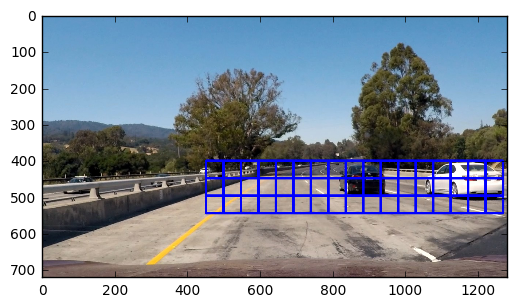

In [26]:
image  = mpimg.imread('test_images/test1.jpg')
window_list1, images_list1 = slide_window(image, [450, None], [400, 550], ( 96,  96), (0.5, 0.5))

plt.imshow(draw_boxes(image, window_list1))
plt.show()

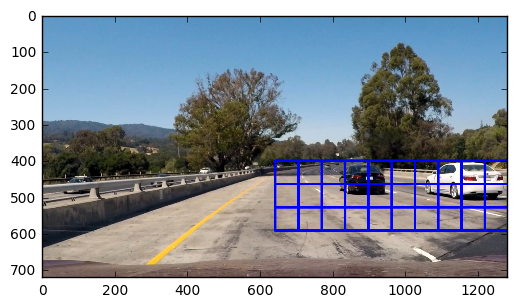

In [27]:
image  = mpimg.imread('test_images/test1.jpg')
window_list1, images_list1 = slide_window(image, [640, None], [400, 600], (128, 128), (0.5, 0.5))

plt.imshow(draw_boxes(image, window_list1))
plt.show()

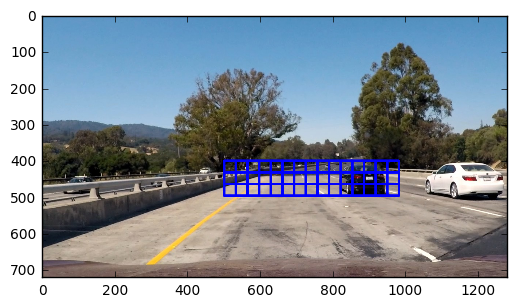

In [28]:
image  = mpimg.imread('test_images/test1.jpg')
window_list1, images_list1 = slide_window(image, [500, 1000], [400, 500], (64, 64), (0.5, 0.5))

plt.imshow(draw_boxes(image, window_list1))
plt.show()

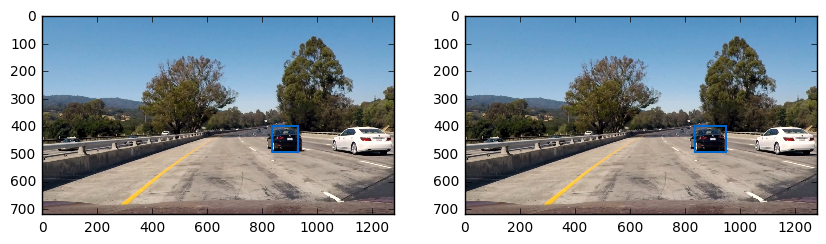

In [29]:
image1  = mpimg.imread('test_images/test1.jpg')

vd = VehicleDetector((720, 1280))
edges1 = vd.process_image(image1)
edges2 = vd.process_image(image1)

fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1,2,1)
plt.imshow(edges1)
fig.add_subplot(1,2,2)
plt.imshow(edges2)
plt.show()

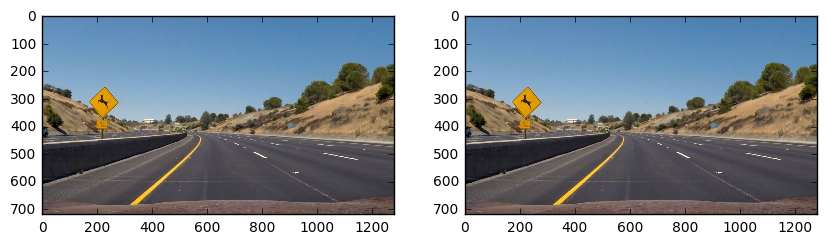

In [30]:
image2 = mpimg.imread('test_images/test2.jpg')

vd = VehicleDetector((720, 1280))
edges1 = vd.process_image(image2)
edges2 = vd.process_image(image2)

fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1,2,1)
plt.imshow(edges1)
fig.add_subplot(1,2,2)
plt.imshow(edges2)
plt.show()

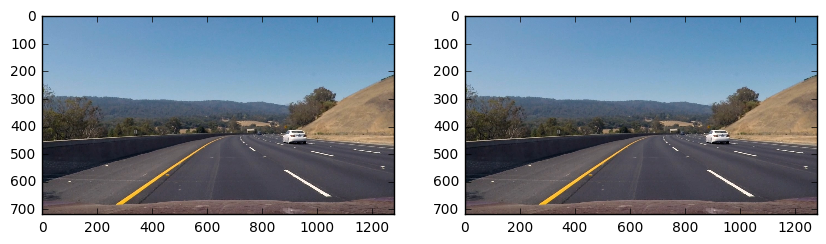

In [31]:
image3 = mpimg.imread('test_images/test3.jpg')

vd = VehicleDetector((720, 1280))
edges1 = vd.process_image(image3)
edges2 = vd.process_image(image3)

fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1,2,1)
plt.imshow(edges1)
fig.add_subplot(1,2,2)
plt.imshow(edges2)
plt.show()

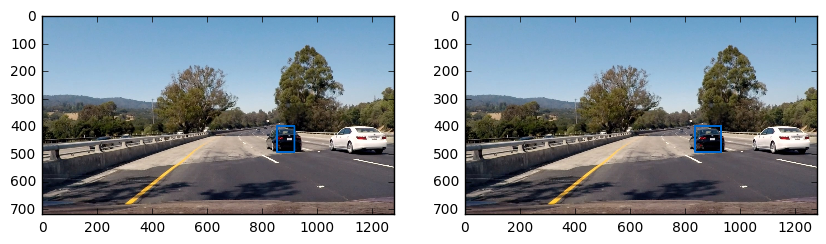

In [32]:
image4 = mpimg.imread('test_images/test4.jpg')

vd = VehicleDetector((720, 1280))
edges1 = vd.process_image(image4)
edges2 = vd.process_image(image4)

fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1,2,1)
plt.imshow(edges1)
fig.add_subplot(1,2,2)
plt.imshow(edges2)
plt.show()

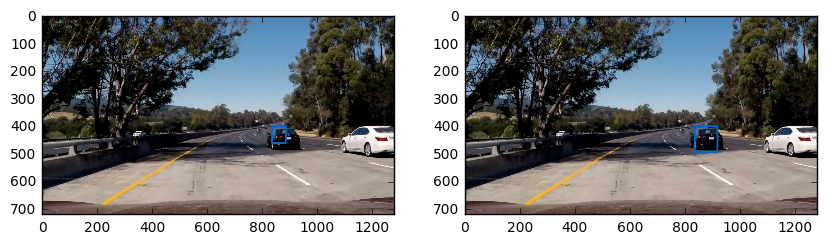

In [33]:
image5 = mpimg.imread('test_images/test5.jpg')

vd = VehicleDetector((720, 1280))
edges1 = vd.process_image(image5)
edges2 = vd.process_image(image5)

fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1,2,1)
plt.imshow(edges1)
fig.add_subplot(1,2,2)
plt.imshow(edges2)
plt.show()

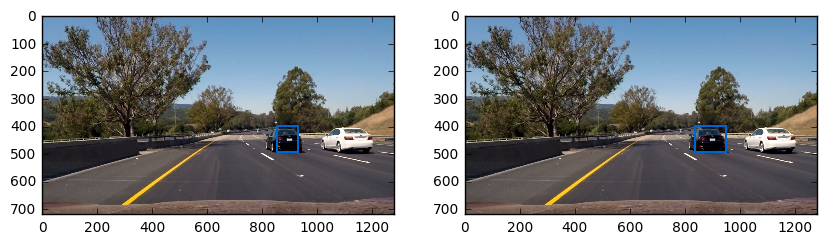

In [34]:
image6 = mpimg.imread('test_images/test6.jpg')

vd = VehicleDetector((720, 1280))
edges1 = vd.process_image(image6)
edges2 = vd.process_image(image6)

fig = plt.figure(figsize=(10, 15))
fig.add_subplot(1,2,1)
plt.imshow(edges1)
fig.add_subplot(1,2,2)
plt.imshow(edges2)
plt.show()

In [35]:
vd = VehicleDetector((720, 1280))
clip   = VideoFileClip('project_video.mp4')
output = clip.fl_image(vd.process_image)
output.write_videofile('output_video/project_video.mp4', audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [15:39<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

